# M2 Control Performance Evaluation under the Slewing Process

This notebook is to evaluate the M2 control performance under the slewing process of telescope mount assembly (TMA).
When the vendor developed M2, the controller was only evaluated and optimized with the maximum velocity of 0.25 deg/sec at the elevation movement, which is only 5% of maximum velocity of TMA.
In addition, there was no evaluation of controller's performance under the azimuth movement before.

Recently, TMA had finished the rebalance with the M1M3 and M2, and performed the slewing in azimuth and elevation directions.
Therefore, we already have some data available to evaluate the M2 control performance.
The main target here is to judge the M2 could support the maximum velocity of TMA based on the current data or not.

## Summary

1. After the slewing of TMA, the M2 can maintain the expected shape once stabilized.
The stabilization time is around 2-3 seconds at 80% velocity with azimuth and elevation movements.
2. M2 should be safe in the slewing process because the maximum tangent force error is around 50% of the default threshold  at 80% velocity with azimuth and elevation movements.

## Import Modules

In [1]:
%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing
from astropy.time import Time
from pandas.core.frame import DataFrame

from lsst.ts.aos.utils import DiagnosticsM2, DiagnosticsMTMount, EfdName

## Declaration of User-Defined Functions

In [2]:
async def plot_rebaseline_moments_yz(
    diagnostics_m2: DiagnosticsM2,
    times_start: list[Time],
    times_end: list[Time],
    legends = list[str],
) -> None:
    """Plot the rebaselined moment-y and moment-z.
    
    Notes
    -----
    The way to do the rebase line here is just a very simple median function.
    Needs to find a better way for this.

    Parameters
    ----------
    diagnostics_m2 : `lsst.ts.aos.utils.DiagnosticsM2`
        M2 diagnostics instance.
    times_start : `list`
        Start times.
    times_end : `list`
        End times.
    legends : `list`
        Legends.
    """

    fig, axs = plt.subplots(1, 2)

    for time_start, time_end in zip(times_start, times_end):
        data_net_moment, time_operation_net_moment = await diagnostics_m2.get_data_net_moment(time_start, time_end)

        axs[0].plot(time_operation_net_moment, data_net_moment.my - np.median(data_net_moment.my))
        axs[1].plot(time_operation_net_moment, data_net_moment.mz - np.median(data_net_moment.mz))

    axs[0].set_title("my")
    axs[1].set_title("mz")

    axs[0].set_ylabel("Moment (N * m)")

    axs[0].set_xlabel("Time (sec)")
    axs[1].set_xlabel("Time (sec)")

    fig.suptitle("Re-baselined Moments")
    fig.tight_layout()
    fig.legend(legends, loc="lower right")

    plt.show()

In [3]:
async def plot_tangent_force_error(
    diagnostics_m2: DiagnosticsM2,
    times_start: list[Time],
    times_end: list[Time],
    legends = list[str],
) -> None:
    """Plot the tangent force error.

    Parameters
    ----------
    diagnostics_m2 : `lsst.ts.aos.utils.DiagnosticsM2`
        M2 diagnostics instance.
    times_start : `list`
        Start times.
    times_end : `list`
        End times.
    legends : `list`
        Legends.
    """

    fig, axs = plt.subplots(4, 2)

    for time_start, time_end in zip(times_start, times_end):
        data_collected = await diagnostics_m2.get_data_force_error_tangent(time_start, time_end)
        
        time_operation = data_collected["timestamp"]
        time_operation_realign = time_operation - time_operation[0]
        
        force = data_collected["force"]

        axs[0, 0].plot(time_operation_realign, force[:, 0])
        axs[0, 1].plot(time_operation_realign, force[:, 1])

        axs[1, 0].plot(time_operation_realign, force[:, 2])
        axs[1, 1].plot(time_operation_realign, force[:, 3])

        axs[2, 0].plot(time_operation_realign, force[:, 4])
        axs[2, 1].plot(time_operation_realign, force[:, 5])

        axs[3, 0].plot(time_operation_realign, data_collected["weight"])
        axs[3, 1].plot(time_operation_realign, data_collected["sum"])

    axs[0, 0].set_title("A1")
    axs[0, 1].set_title("A2")
    axs[1, 0].set_title("A3")
    axs[1, 1].set_title("A4")
    axs[2, 0].set_title("A5")
    axs[2, 1].set_title("A6")
    axs[3, 0].set_title("weight")
    axs[3, 1].set_title("sum")

    for idx in range(4):
        axs[idx, 0].set_ylabel("Force Error (N)")

    for idx in range(2):
        axs[-1, idx].set_xlabel("Time (sec)")

    fig.suptitle("Tangent Force Error")
    fig.tight_layout()
    fig.legend(legends, loc="lower right")

    plt.show()

## Instantiate the Diagnostics Classes

In [4]:
diagnostics_m2 = DiagnosticsM2(efd_name=EfdName.Usdf)
diagnostics_mtmount = DiagnosticsMTMount(efd_name=EfdName.Usdf)

## Times of the Tests

In [5]:
# Only the elevation movement
time_start_el_20_az_0 = Time("2023-11-16T03:19:16", scale="utc", format="isot")
time_end_el_20_az_0 = Time("2023-11-16T03:20:05", scale="utc", format="isot")

time_start_el_30_az_0 = Time("2023-11-16T03:46:14", scale="utc", format="isot")
time_end_el_30_az_0 = Time("2023-11-16T03:46:56", scale="utc", format="isot")

time_start_el_40_az_0 = Time("2023-11-16T06:48:00", scale="utc", format="isot")
time_end_el_40_az_0 = Time("2023-11-16T06:48:40", scale="utc", format="isot")

time_start_el_60_az_0 = Time("2023-11-18T23:13:52", scale="utc", format="isot")
time_end_el_60_az_0 = Time("2023-11-18T23:14:40", scale="utc", format="isot")

time_start_el_80_az_0 = Time("2023-11-19T00:51:22", scale="utc", format="isot")
time_end_el_80_az_0 = Time("2023-11-19T00:51:48", scale="utc", format="isot")

# Elevation and azimuth movements
time_start_el_10_az_10 = Time("2023-11-16T02:56:39", scale="utc", format="isot")
time_end_el_10_az_10 = Time("2023-11-16T03:00:23", scale="utc", format="isot")

time_start_el_20_az_20 = Time("2023-11-16T03:24:09", scale="utc", format="isot")
time_end_el_20_az_20 = Time("2023-11-16T03:24:55", scale="utc", format="isot")

time_start_el_30_az_30 = Time("2023-11-16T03:44:39", scale="utc", format="isot")
time_end_el_30_az_30 = Time("2023-11-16T03:45:43", scale="utc", format="isot")

time_start_el_40_az_40 = Time("2023-11-16T06:43:07", scale="utc", format="isot")
time_end_el_40_az_40 = Time("2023-11-16T06:43:54", scale="utc", format="isot")

time_start_el_60_az_60 = Time("2023-11-18T23:22:36", scale="utc", format="isot")
time_end_el_60_az_60 = Time("2023-11-18T23:23:21", scale="utc", format="isot")

time_start_el_80_az_80 = Time("2023-11-19T00:32:32", scale="utc", format="isot")
time_end_el_80_az_80 = Time("2023-11-19T00:33:24", scale="utc", format="isot")

## Change of the Moment Y and Z

### Only Elevation Movement

The following figure compares the re-baselined moments y and z under the elevation velocity of 20% - 80% of TMA maximum value.
There is no azimuth movement.
We only care about the peaks here because they might break the mirror.
These peaks come from the overshoot/undershoot in the acceleration/deceleration process. 
At the 80% velocity, the peak of $m_{y}$ is around 16 $N*m$ and the peak of $m_{z}$ is around 30 $N*m$.
Once the overshoot/undershoot happens, the controller can stabilize in less than 1 sec. 

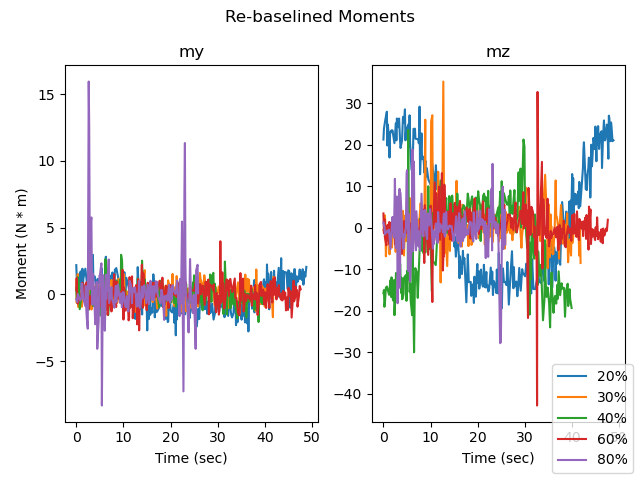

In [6]:
await plot_rebaseline_moments_yz(
    diagnostics_m2,
    [time_start_el_20_az_0, time_start_el_30_az_0, time_start_el_40_az_0, time_start_el_60_az_0, time_start_el_80_az_0],
    [time_end_el_20_az_0, time_end_el_30_az_0, time_end_el_40_az_0, time_end_el_60_az_0, time_end_el_80_az_0],
    ["20%", "30%", "40%", "60%", "80%"],
)

### Elevation and Azimuth Movements

The following figure compares the re-baselined moments y and z under the elevation and azimuth velocities of 20% - 80% of TMA maximum value.
We can see the peaks are significantly higher than the case that has no azimuth movement.

At the 80% velocity, the peak of $m_{y}$ is around 130 $N*m$ and the peak of $m_{z}$ is around 350 $N*m$.
Once the overshoot/undershoot happens, the controller can stabilize around 2 sec. 

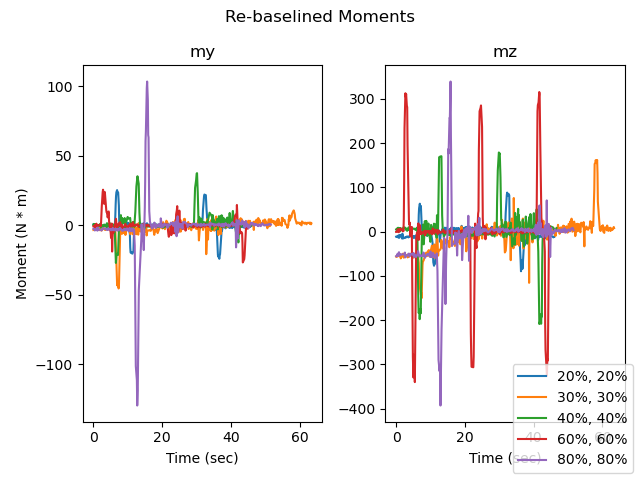

In [7]:
await plot_rebaseline_moments_yz(
    diagnostics_m2,
    [time_start_el_20_az_20, time_start_el_30_az_30, time_start_el_40_az_40, time_start_el_60_az_60, time_start_el_80_az_80],
    [time_end_el_20_az_20, time_end_el_30_az_30, time_end_el_40_az_40, time_end_el_60_az_60, time_end_el_80_az_80],
    ["20%, 20%", "30%, 30%", "40%, 40%", "60%, 60%", "80%, 80%"],
)

## Check the Tangent Force Errors

The M2 control system will check the tangent force errors with 20 Hz frequency.
If the force errors are higher than the thresholds, the M2 will transition to the **Fault** state to protect the mirror.
List the default thresholds in the following (the unit is Newton):

**TANGENT_LINK_TOTAL_WEIGHT_ERROR** = 2000

**TANGENT_LINK_LOAD_BEARING_LINK** = 1000

**TANGENT_LINK_THETA_Z_MOMENT** = 1000

**TANGENT_LINK_NON_LOAD_BEARING_LINK** = 1000

### Only Elevation Movement

For the tangent links A1 and A4, the maximum peak of force error is around 78 N at 80% velocity, which is pretty small compared with **TANGENT_LINK_NON_LOAD_BEARING_LINK**.
For the tangent links A2, A3, A5, and A6, the maximum peak of force error is around -320 N at 80% velocity, which has the margin of 680 N to reach the **TANGENT_LINK_LOAD_BEARING_LINK**.
For the mirror weight error, the maximum peak of force error is around 1040 N at 80% velocity, which has the margin of 960 N to reach the **TANGENT_LINK_TOTAL_WEIGHT_ERROR**.
For the summation error (aka. $m_{z}$), the values are small compared with the **TANGENT_LINK_THETA_Z_MOMENT**.

Once the overshoot/undershoot happens, the controller needs around 3 sec to stabilize at 80% velocity.

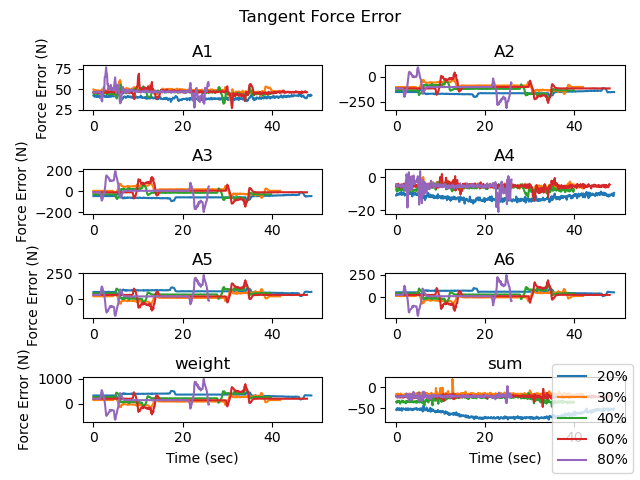

In [10]:
await plot_tangent_force_error(
    diagnostics_m2,
    [time_start_el_20_az_0, time_start_el_30_az_0, time_start_el_40_az_0, time_start_el_60_az_0, time_start_el_80_az_0],
    [time_end_el_20_az_0, time_end_el_30_az_0, time_end_el_40_az_0, time_end_el_60_az_0, time_end_el_80_az_0],
    ["20%", "30%", "40%", "60%", "80%"],
)

### Elevation and Azimuth Movements

For the tangent links A1 and A4, the maximum peak of force error is around 280 N at 80% velocity, which has the margin of 720 N to reach the **TANGENT_LINK_NON_LOAD_BEARING_LINK**.
For the tangent links A2, A3, A5, and A6, the maximum peak of force error is around -310 N at 80% velocity, which has the margin of 690 N to reach the **TANGENT_LINK_LOAD_BEARING_LINK**.
For the mirror weight error, the maximum peak of force error is around 1000 N at 80% velocity, which has the margin of 1000 N to reach the **TANGENT_LINK_TOTAL_WEIGHT_ERROR**.
For the summation error (aka. $m_{z}$), the maximum peak of force error is around -250 N at 80% velocity, which has the margin of 750 N to reach the **TANGENT_LINK_THETA_Z_MOMENT**.

Once the overshoot/undershoot happens, the controller needs around 3 sec to stabilize at 80% velocity.

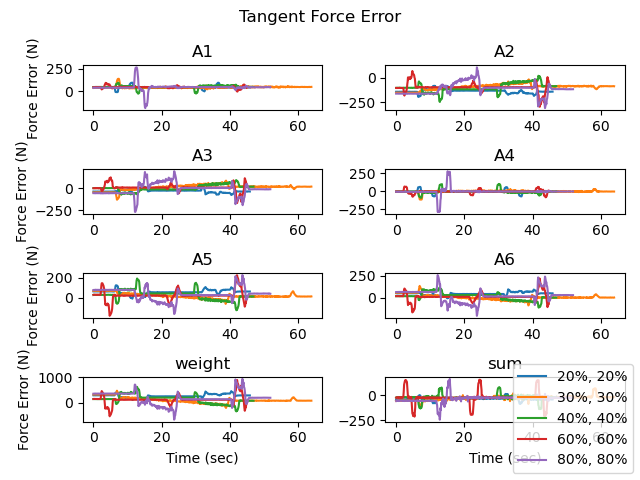

In [11]:
await plot_tangent_force_error(
    diagnostics_m2,
    [time_start_el_20_az_20, time_start_el_30_az_30, time_start_el_40_az_40, time_start_el_60_az_60, time_start_el_80_az_80],
    [time_end_el_20_az_20, time_end_el_30_az_30, time_end_el_40_az_40, time_end_el_60_az_60, time_end_el_80_az_80],
    ["20%, 20%", "30%, 30%", "40%, 40%", "60%, 60%", "80%, 80%"],
)

In [ ]:
plt.close("all")